## INF-578. Machine Learning. Tarea 3.
# Métodos No-Lineales

## Álvaro Salinas -  Camilo Valenzuela

## 22 de Diciembre de 2017

### Tabla de Contenidos

* [Librerías Necesarias](#libs)
* [Pregunta 1](#1)
    * [1.a](#1a)
    * [1.b](#1b)
    * [1.c](#1c)
    * [1.d](#1d)
    * [1.e](#1e)
    * [1.f](#1f)
    * [1.g](#1g)
* [Pregunta 2](#2)
    * [2.a](#2a)
    * [2.b](#2b)
    * [2.c](#2c)
    * [2.d](#2d)
    * [2.e](#2e)
    * [2.f](#2f)
    * [2.g](#2g)
    * [2.h](#2h)
    * [2.i](#2i)
* [Pregunta 3](#3)
    * [3.a](#3a)
    * [3.b](#3b)
    * [3.c](#3c)
    * [3.d](#3d)
    * [3.e](#3e)
    * [3.f](#3f)
    * [3.g](#3g)
* [Pregunta 4](#4)
    * [4.a](#4a)
    * [4.b](#4b)
    * [4.c](#4c)
    * [4.d](#4d)
    * [4.e](#4e)
    * [4.f](#4f)
    
<div id='libs' />
### Librerías necesarias

In [1]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Pregunta 1
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.decomposition import KernelPCA

# Pregunta 2
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact,fixed
from sklearn.svm import SVR

# Pregunta 3
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Pregunta 4
from sklearn.preprocessing import StandardScaler
from keras.layers import Activation
from keras.utils.np_utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import time

%matplotlib inline

Using Theano backend.


<div id='1' />
### 1. Small Circle inside Large Circle

<div id='1a' />
##### (a) Escriba una función que genere (aleatoriamente) $n$ datos etiquetados de la forma $\{(x_1, y_1), . . . ,(x_n, y_n)\}, x_i \in \mathbb{R}^2, y_i \in \{0, 1\}$, con una distribución de probabilidad que refleje la configuración linealmente inseparable que muestra la Fig. 13. Utilice esta función para crear $1000$ datos de entrenamiento y $1000$ datos de pruebas. Para medir la tendencia de los modelos a sobre-ajuste, agregue un $5 %$ de ruido al dataset, generando $x$’s cercanos a la frontera. Genere un gráfico que muestre datos de entrenamiento y pruebas, identificando cada clase con un color diferente (como lo muestra la Fig. 1).

In [3]:
def do_circles(n=2000,noisy_n=0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)

    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),
        np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp),
        np.ones(n // 2, dtype=np.intp)])
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.5, random_state=42)
    return X_train,y_train,X_test,y_test

In [4]:
X_train, Y_train,X_test,Y_test= do_circles()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].scatter(X_train[Y_train == 0,0],X_train[Y_train == 0,1],label="Clase 0")
ax[0].scatter(X_train[Y_train == 1,0],X_train[Y_train == 1,1],label="Clase 1")
ax[0].set_title("Train Data")
ax[1].scatter(X_test[Y_test == 0,0],X_test[Y_test == 0,1],label="Clase 0")
ax[1].scatter(X_test[Y_test == 1,0],X_test[Y_test == 1,1],label="Clase 1")
ax[1].set_title("Test Data")
ax[0].legend()
ax[1].legend()
plt.show()

In [6]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
    f, ax = plt.subplots(1, 1,figsize=(9, 8))
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
   
    if hasattr(clf, "decision_function"):
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    else:
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

    Z = Z.reshape(XX.shape) > 0.5
    ax.contourf(XX, YY, Z, cmap=cm, alpha=.8)
    
    ax.scatter(X_train[:,0],X_train[:,1],c=Y_train, cmap=cm_bright,
                   edgecolors='k')
    ax.scatter(X_test[:,0],X_test[:,1],c=Y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.7)
    ax.set_xlim(XX.min(), XX.max())
    ax.set_ylim(YY.min(), YY.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.show()

<div id='1b' />
##### (b) Demuestre experimentalmente que una red neuronal artificial correspondiente a 1 sola neurona (i.e. sin capas escondidas) no puede resolver satisfactoriamente el problema. Puede utilizar la función de activación y el método de entrenamiento que prefiera. Sea convincente: por ejemplo, intente modificar los parámetros de la máquina de aprendizaje, reportando métricas que permitan evaluar el desempeño del modelo en el problema con cada cambio efectuado. Adapte también la función plot_classifier para que represente gráficamente la solución encontrada por la red neuronal. Describa y explique lo que observa, reportando gráficos de la solución sólo para algunos casos representativos.

In [ ]:
n_h=1
activation = "sigmoid"
for activation in ["sigmoid", "tanh","relu"]:
    np.random.seed(0)
    model = Sequential()
    model.add(Dense(n_h,input_dim=X_train.shape[1], activation=activation))
    model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, Y_train, epochs=100, batch_size=100, verbose=0)
    scores = model.evaluate(X_test, Y_test)
    test_acc = scores[1]
    plot_classifier(model,X_train,Y_train,X_test,Y_test,"ann")
    print(activation, ":",test_acc)

# No se que estoy haciendo mal acá nada funciona :/ 

<div id='1c' />
##### (c) Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema obtenido en (a). Puede utilizar la arquitectura y el método de entrenamiento que prefiera, pero en esta actividad puede optar tranquilamente por usar los hiper-parámetros que se entregan como referencia en el código de ejemplo. Cambie el número de neuronas $N_h$ en la red entre $2$ y $32$ en potencias de $2$, graficando el error de entrenamiento y pruebas como función de $N_h$. Describa y explique lo que observa. Utilice la función plot classifier, diseñada anteriormente, para construir gráficos de la solución en algunos casos representativos.

In [ ]:
acc_list = []
activation = "sigmoid"
n_hs = np.logspace(1,5,base=2,num=5,dtype=int)
for n_h in n_hs:
    print(n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation=activation))
    
    #Se agrega esta capa para tener la dimensión de output = 1 
    model.add(Dense(1, kernel_initializer='uniform', activation=activation))
    model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, Y_train, epochs=100, batch_size=100, verbose=0)
    scores = model.evaluate(X_test, Y_test)
    test_acc = scores[1]
    print("Accuracy:",test_acc)
    plot_classifier(model,X_train,Y_train,X_test,Y_test,"ann")

## Árboles de Clasificación 

<div id='1d' />
##### (d) Demuestre experimentalmente que stump (árbol de clasificación de 1 nivel) no puede resolver satisfactoriamente el problema anterior. Puede utilizar el criterio y la función de partición que prefiera. Sea convincente: por ejemplo, intente modificar los parámetros de la máquina, reportando mátricas que permitan evaluar el desempeño del modelo en el problema con cada cambio efectuado. Adapte también la función plot_classifier para que represente gráficamente la solución encontrada por el árbol. Describa y explique lo que observa, reportando gráficos de la solución sólo para algunos casos representativos.

In [ ]:
clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=1)
clf.fit(X_train,Y_train)
acc_test = clf.score(X_test,Y_test)
print("Test Accuracy = %f"%acc_test)
print(clf.tree_.max_depth)
plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree')

<div id='1e' />
##### (e) Demuestre experimentalmente que un árbol de clasificación de múltiples niveles puede resolver satisfactoriamente el problema estudiado. Puede utilizar el criterio y la función de partición que prefiera, pero puede optar tranquilamente por usar los hiper-parámetros que se entregan como referencia en el código de ejemplo. Cambie el número de niveles admitidos en el árbol $N_t$ entre $2$ y $20$, graficando el error de entrenamiento y pruebas como función de $N_t$. Describa y explique lo que observa. Utilice la función plot_classifier, diseñada anteriormente, para construir gráficos de la solución en algunos casos representativos.

In [ ]:
n_ts = list(range(2,22,2))
acc_tests = []
acc_trains = []
for n_t in n_ts:
    clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
    clf.fit(X_train,Y_train)
    acc_test = clf.score(X_test,Y_test)
    acc_train = clf.score(X_train,Y_train)
    if n_t < 7:
        print("Max Depth:", n_t)
        plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree')  
    acc_tests.append(acc_test)
    acc_trains.append(acc_train)

In [ ]:
plt.axvline(n_ts[np.argmax(acc_trains)], color="red", ls="--")
plt.plot(n_ts,acc_tests,label="Accuracy Test")
plt.plot(n_ts,acc_trains,label="Accuracy Train")
plt.xticks(n_ts,label="Max Train")
plt.ylim(bottom=np.min(acc_tests))
plt.legend()
plt.show()

## Manifold (KernelPCA)

<div id='1f' />
##### (f) Como ya se demostró experimentalmente que este problema es linealmente inseperable, ahora se pide experimentar otra alternativa. Para ello deberá realizar una proyección de los datos a un nuevo espacio dimensional (manifold) en el cual se reconozcan sus patrones no lineales, para poder trabajarlos con fronteras lineales. Utilice la técnica de PCA con la ayuda de un Kernel Gaussiano para extraer sus vectores con dimensión infinita de mayor varianza.

In [240]:
kpca = KernelPCA(n_components=2,kernel="rbf", gamma=5)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

<div id='1g' />
##### (g) Ajuste un algoritmo de aprendizaje con fronteras lineal para los datos proyectados en este nuevo espacio que captura sus componentes no lineales, muestre graficamente que el problema ahora puede ser resuelto con estos métodos. Reporte métricas para evaluar el desempeño, comente y concluya.

In [ ]:
acc_list = []
activation = "sigmoid"
n_hs = np.logspace(1,5,base=2,num=5,dtype=int)
for n_h in n_hs:
    print(n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=Xkpca_train.shape[1], kernel_initializer='uniform'))
    model.add(Dense(1, kernel_initializer='uniform', activation=activation))
    model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(Xkpca_train, Y_train, epochs=100, batch_size=100, verbose=0)
    scores = model.evaluate(Xkpca_test, Y_test)
    test_acc = scores[1]
    print("Accuracy:",test_acc)
    plot_classifier(model,Xkpca_train,Y_train,Xkpca_test,Y_test,"ann")

### Arbol de Clasificación

In [ ]:
n_ts = list(range(2,22,2))
acc_tests = []
acc_trains = []
for n_t in n_ts:
    clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
    clf.fit(Xkpca_train,Y_train)
    acc_test = clf.score(Xkpca_test,Y_test)
    acc_train = clf.score(Xkpca_train,Y_train)
    if n_t < 7:
        print("Max Depth:", n_t)
        plot_classifier(clf,Xkpca_train,Y_train,Xkpca_test,Y_test,'tree')  
    acc_tests.append(acc_test)
    acc_trains.append(acc_train)

In [ ]:
plt.axvline(n_ts[np.argmax(acc_tests)], color="red", ls="--")
plt.plot(n_ts,acc_tests,label="Accuracy Test")
plt.plot(n_ts,acc_trains,label="Accuracy Train")
plt.xticks(n_ts)
plt.ylim(bottom=np.min(acc_tests))
plt.legend()
plt.show()

# Pregunta 2

In [ ]:
dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])
df = df.drop("Unnamed: 0",axis=1)
print('\nSummary - dataframe completo:\n')
df.describe()


Summary - dataframe completo:



,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


In [ ]:
fig,ax  = plt.subplots(2,6, figsize=(20,8))
ax = ax.ravel()
for i,column in enumerate(df.drop("datetime",axis=1).columns):
    sns.distplot(df[column],ax=ax[i])
plt.show()

In [ ]:
def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

In [ ]:
Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour']]
Ydf=df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

In [ ]:
#Creando Regression Tree
model = Tree(random_state=0)
model.fit(X_train,Y_train)

#Calculando Test Score
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

#Calculando Kaggle Score para cada conjunto
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test) #Deberia volver a entrenar el modelo con Train + Val para este

kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)

#Mostrando valores de kaggle score
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL TEST =%f"%kagg_test)

#Plot de test vs predicción 
#deberia ser una recta en 45°
plt.plot(Y_test,Y_pred_test,'.')
plt.xlabel("y-test")
plt.ylabel("y-predicted")
plt.show()

In [ ]:
"""
Función para realizar una visualización interactiva del
score y plot y-real vs y-pred

"""
def interact_depth(data,  max_depth=20, interactive=True):
    X_train, Y_train, X_test, Y_test, X_val, Y_val = data
    model = Tree(random_state=0,max_depth=max_depth)
    model.fit(X_train,Y_train)
    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    Y_pred_train = model.predict(X_train)

    kagg_train = eval_bikemodel(Y_pred_train,Y_train)
    
    #Solo si es interactivo muestra el plot y 
    #los kaggle score respectivos
    if interactive:
        fig,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(15,6))
        ax1.plot(Y_pred_val,Y_val,'.')
        ax1.set_xlabel("y-val")
        ax1.set_ylabel("y-predicted")
        ax1.set_title("Validation Set")
        
        
        # Aca se deberia concatenar validation y train
        # y luego realizar la predicción para ser
        # más justos
#         X_train_full = np.vstack([X_train,X_val])
#         y_train_full = np.hstack([Y_train,Y_val])

#         model.fit(X_train_full,y_train_full)
        
        Y_pred_test = model.predict(X_test)
        kagg_test = eval_bikemodel(Y_pred_test,Y_test)
        ax2.plot(Y_pred_test,Y_test,'.')
        ax2.set_xlabel("y-test")
        ax2.set_ylabel("y-predicted")        
        ax1.set_title("Test Set")
        
        plt.show()
        print("KAGG EVAL TRAIN =%f"%kagg_train)
        print("KAGG EVAL VAL =%f"%kagg_val)
        print("KAGG EVAL TEST =%f"%kagg_test)
    return kagg_train,kagg_val

In [ ]:
#Fitteando arboles con distinta profundidad
#maxima para luego seleccionar el mejor

limit_depth = 30
kagg_values_val = []
kagg_values_train = []
for max_depth in range(1,limit_depth+1):
    kagg_train,kagg_val = interact_depth((X_train, Y_train, X_test, Y_test, X_val, Y_val) ,max_depth, False)
    kagg_values_train.append(kagg_train)    
    kagg_values_val.append(kagg_val)

In [ ]:
#Graficando los resultados a diferentes profundidades maximaslimit_depth+1
plt.plot(list(range(1,limit_depth+1)), kagg_values_train)
plt.plot(list(range(1,limit_depth+1)), kagg_values_val)

plt.title("Validation Kaggle Score")
plt.ylabel("Kaggle Score")
plt.xlabel("Max Depth")
plt.legend(["Train", "Validation"])
plt.show()

best_depth = np.argmin(kagg_values_val)+1
print("Best Validation Depth:",best_depth)

Al seguir aumentando el `max_depth` se tiende a realizar overfitting de los datos por lo que el score sigue disminuyendo en el train pero en el conjunto de validación se mantiene constante hasta disminuye en algunos tramos.

In [ ]:
_= interact(interact_depth,data = fixed((X_train, Y_train, X_test, Y_test, X_val, Y_val)),max_depth=(1,limit_depth),interactive=fixed(True))

<div id='3' />
### 3. Calidad de un Vino

<div id='3a' />
##### (a) Carge los dos dataset en un único dataframe de pandas, además de agregar una columna indicando si es vino tinto o blanco. Describa el dataset a trabajar.

El dataset muestra distintas características de vinos, como su densidad, pH, alcohol, acidez, entre otros. Se cuenta con 1599 ejemplos de vino tinto y 4898 de vino blanco, obteniendo un total de 6497 ejemplos. Como se verá en la siguiente pregunta, la característica objetivo corresponde a la calidad del vino, la cual corresponde a un valor entero entre 1 y 10, pero que para simplificar el problema será tratado únicamente como un valor booleano que indica si el vino es de buena calidad ($>5$) o mala calidad ($\leq 5$).

In [22]:
df_red = pd.read_csv("winequality-red.csv",sep=";")
df_red['tipo'] = 1
df_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,tipo
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.0
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023,1.0
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569,0.0
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,1.0
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,1.0
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000,1.0
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000,1.0
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.0


In [23]:
df_white = pd.read_csv("winequality-white.csv",sep=";")
df_white['tipo'] = 0
df_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,tipo
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.0
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909,0.0
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639,0.0
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.0
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000,0.0
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000,0.0
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000,0.0
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000,0.0


In [24]:
df = pd.concat([df_red,df_white], axis=0)
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,tipo
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


<div id='3b' />
##### (b) Aborde este problema como si fuera de clasificación binaria para predecir si un vino es de calidad o no, es decir, utilice las distintas características fisioquímicas presentes en los datos para estimar esta etiqueta. Para esto cree las matrices de entrenamiento y de pruebas, además de la etiqueta para ambos conjuntos, considerando como quality mayor a $5$ un vino de buena calidad. El conjunto de pruebas ($25 \%$) será utilizado únicamente para verificar la calidad de los algoritmos a entrenar.

In [25]:
df['good_quality'] = [1 if q>5 else 0 for q in df.quality]
df = df.drop(columns=['quality'])
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,tipo,good_quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.246114,0.633061
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.430779,0.482007
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,0.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,0.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000,1.000000


In [26]:
df = df.sample(frac=1).reset_index(drop=True)
df_tr = df[1624:]
df_t  = df[:1624]

In [27]:
x_tr,y_tr = df_tr.drop(columns=['good_quality']), df_tr['good_quality']
x_t ,y_t  = df_t.drop(columns=['good_quality']), df_t['good_quality']

<div id='3c' />
##### (c) Entrene un solo Arbol de Clasificación de múltiples niveles para resolver el problema. Puede variar los hiper-parámetros que prefiera, recuerde que las decisiones no pueden ser basadas mirando el conjunto de pruebas. Debido al desbalanceo que se produce en las dos clases mida la métrica F1-score sobre el conjunto de entrenamiento y de pruebas.

Para encontrar los hierparámetros, primero hemos decidido crear un conjunto de validación extrayendo 1000 ejemplos del conjunto de entrenamiento. Los parámetros probados fueron Criterion (gini o entropy), Splitter (best o random), y la profundidad máxima del árbol (desde 1 a 50). Para la mayoría de las alturas permitidas, la combinación gini-best obtuvo los mejores resultados. Otro punto interesante es que a partir de una altura máxima igual a 30, los f1-scores alcanzados se mantienen constantes, por lo que es posible concluir que a pesar de permitirle una altura mayor, los árboles no continuan dividiendo sus hojas a partir de ese valor. 

A pesar de haber elegido la combinación ganadora (gini-best), el máximo f1-score alcanzado lo obtuvo la combinación entropy-best con una altura máxima de 14. Pero al decidir aplicar ambos modelos al testing set, gini-best obtuvo un mejor resultado.

In [28]:
x_v , y_v  = x_tr[:1000], y_tr[:1000]
x_tr, y_tr = x_tr[1000:], y_tr[1000:]

In [29]:
scors = []
for cri in ['gini', 'entropy']:
    for spli in ['best', 'random']:
        scor = []
        for depth in range(1,51):
            clf=Tree(criterion=cri,splitter=spli,random_state=0,max_depth=depth)
            clf.fit(x_tr,y_tr)
            y_p = clf.predict(x_v)
            scor.append(f1_score(y_v,y_p))
        scors.append((scor,cri,spli))

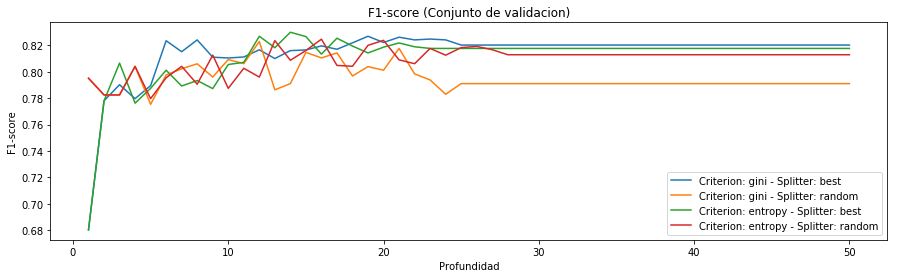

In [30]:
plt.figure(figsize=(15,4))
for scor, cri, spli in scors:
    plt.plot(range(1,51),scor, label='Criterion: '+cri+' - Splitter: '+spli)
plt.title("F1-score (Conjunto de validacion)")
plt.xlabel("Profundidad")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [34]:
clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=19)
clf.fit(x_tr,y_tr)
y_p = clf.predict(x_t)
f1t1 = f1_score(y_t,y_p)
print "F1-score (Conjunto de Prueba) = %f"%f1t1

F1-score (Conjunto de Prueba) = 0.815311


In [35]:
clf=Tree(criterion='entropy',splitter='best',random_state=0,max_depth=14)
clf.fit(x_tr,y_tr)
y_p = clf.predict(x_t)
print "F1-score (Conjunto de Prueba) = %f"%f1_score(y_t,y_p)

F1-score (Conjunto de Prueba) = 0.814326


<div id='3d' />
##### (d) Entrene un ensamblador de árboles de múltiples niveles, mediante la técnica de Random Forest. Varíe la cantidad de árboles de decisión utilizados en el ensamblado ($n$ estimators), realice un gráfico resumen del F1-score de entrenamiento y de pruebas en función de este hiper-parámetro.

Se aprecia como Random Forest tiene un comportamiento muy superior al entrenamiento con un solo árbol. Con un número pequeño de estimadores ($<5$) no presenta un comportamiento estable, alcanzando su peor desempeño con 2 estimadores. Para un número más grande de estimadores, el comportamiento mejora bastante superando por un amplio margen el resultado obtenido en la pregunta anterior.

In [42]:
scor_tr_RF = []
scor_t_RF  = []
for n in range(1,101):
    model = RandomForestClassifier(n_estimators=n, max_depth=19,n_jobs=-1)
    model.fit(x_tr,y_tr)
    y_tr_p = model.predict(x_tr)
    y_t_p = model.predict(x_t)
    scor_tr_RF.append(f1_score(y_tr,y_tr_p))
    scor_t_RF.append(f1_score(y_t,y_t_p))

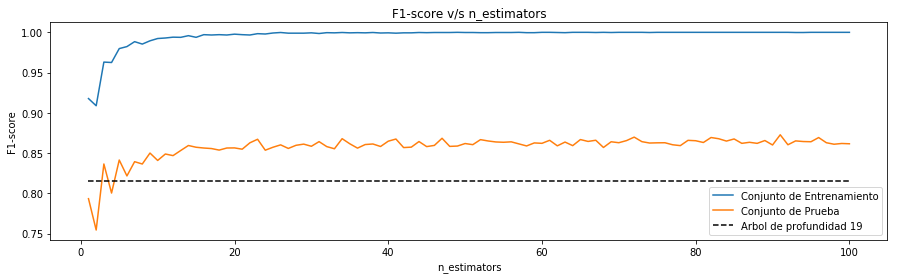

In [43]:
plt.figure(figsize=(15,4))
plt.plot(range(1,101),scor_tr_RF, label="Conjunto de Entrenamiento")
plt.plot(range(1,101),scor_t_RF, label="Conjunto de Prueba")
plt.plot([1,100],[f1t1,f1t1],'k--', label='Arbol de profundidad 19')
plt.title("F1-score v/s n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [44]:
print max(scor_t_RF)

0.872761545712


<div id='3e' />
##### (e) Entrene un ensamblador de árboles de múltiples niveles, mediante la técnica de AdaBoost. Varíe la cantidad de árboles de decisión utilizados en el ensamblado ($n$ estimators), realice un gráfico resumen del F1-score de entrenamiento y de pruebas en función de este hiper-parámetro. Compare y analice con la técnica utilizada en (d).

Adaboost presenta un comportamiento bastante similar a Random Forest con árboles de altura máxima 19, pero su desempeño resulta ser mejor con un número pequeño de estimadores.

In [45]:
scor_tr_AB = []
scor_t_AB  = []
for n in range(1,101):
    model = AdaBoostClassifier(base_estimator=Tree(max_depth=19), n_estimators=n)
    model.fit(x_tr,y_tr)
    y_tr_p = model.predict(x_tr)
    y_t_p = model.predict(x_t)
    scor_tr_AB.append(f1_score(y_tr,y_tr_p))
    scor_t_AB.append(f1_score(y_t,y_t_p))

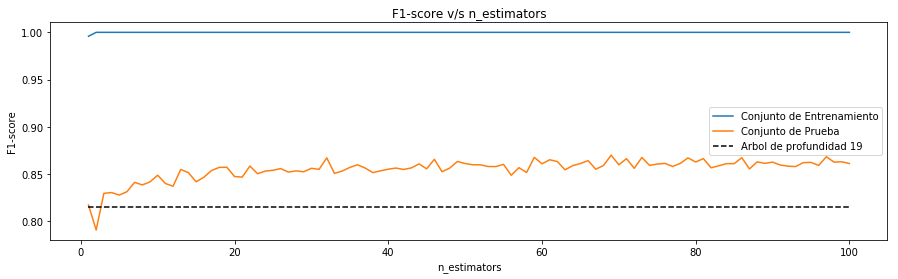

In [46]:
plt.figure(figsize=(15,4))
plt.plot(range(1,101),scor_tr_AB, label="Conjunto de Entrenamiento")
plt.plot(range(1,101),scor_t_AB, label="Conjunto de Prueba")
plt.plot([1,100],[f1t1,f1t1],'k--', label='Arbol de profundidad 19')
plt.title("F1-score v/s n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [49]:
print max(scor_t_AB)

0.870009285051


A continuación se presenta un gráfico que compara el desempeño de todos los experimentos realizados hasta el momento. Podemos ver como Adaboost y Random Forest superan ampliamente al entrenamiento con un solo árbol de decisión. El máximo f1-score alcanzado por Random Forest es levemente superior al máximo obtenido mediante Adaboost.

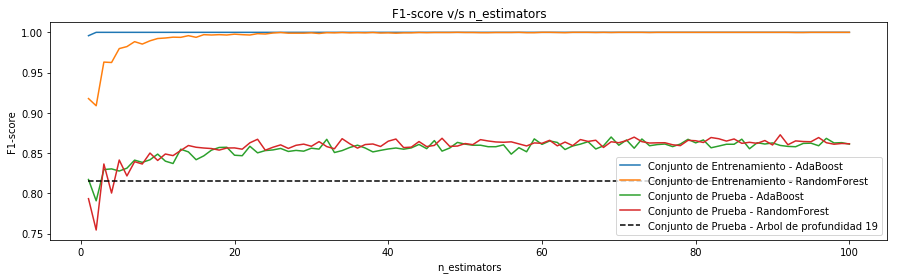

In [48]:
plt.figure(figsize=(15,4))
plt.plot(range(1,101),scor_tr_AB, label="Conjunto de Entrenamiento - AdaBoost")
plt.plot(range(1,101),scor_tr_RF, label="Conjunto de Entrenamiento - RandomForest")
plt.plot(range(1,101),scor_t_AB, label="Conjunto de Prueba - AdaBoost")
plt.plot(range(1,101),scor_t_RF, label="Conjunto de Prueba - RandomForest")
plt.plot([1,100],[f1t1,f1t1],'k--', label="Conjunto de Prueba - Arbol de profundidad 19")
plt.title("F1-score v/s n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("F1-score")
plt.legend(loc=4)
plt.show()

<div id='3f' />
##### (f) Entrene alguna otra máquina de aprendizaje, elegida por usted, para resolver este problema. Elija los hiper-parámetros que estime convenientes intentando aumentar el F1-score obtenido por los algoritmos anteriores. Compare y analice estas 4 maneras de resolver el problema definido en (b).

Se probaron varias configuraciones (todas evaluadas con el conjunto de validación). A continuación se muestra la que obtuvo mejor desempeño, correspondiente a un preprocesamiendo de los datos con LDA y un posterior entrenamiendo de una red neuronal con una única capa oculta de 50 neuronas y función de activación relu, con una sigmoidal en la salida. El f1-score obtenido no logra superar siquiera al árbol individual de altura 19. Se estima que con una SVM se podría mejorar el resultado encontrado.

In [50]:
lda = LDA(n_components=5)
lda.fit(x_tr,y_tr)
x_tr_lda = lda.transform(x_tr)
x_t_lda = lda.transform(x_t)
x_v_lda = lda.transform(x_v)
    
model = Sequential()
model.add(Dense(50, input_dim=x_tr_lda.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_tr_lda, y_tr, epochs=100, batch_size=128, verbose=0, validation_data=(x_v_lda,y_v))

y_p = model.predict(x_t_lda)
f1t = f1_score(y_t,(np.sign(y_p-0.5)+1)/2)
print "F1-score (Conjunto de Prueba) = %f"%f1t

F1-score (Conjunto de Prueba) = 0.810104


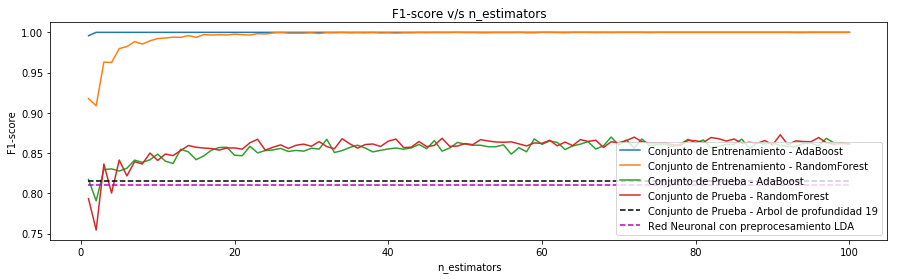

In [52]:
plt.figure(figsize=(15,4))
plt.plot(range(1,101),scor_tr_AB, label="Conjunto de Entrenamiento - AdaBoost")
plt.plot(range(1,101),scor_tr_RF, label="Conjunto de Entrenamiento - RandomForest")
plt.plot(range(1,101),scor_t_AB, label="Conjunto de Prueba - AdaBoost")
plt.plot(range(1,101),scor_t_RF, label="Conjunto de Prueba - RandomForest")
plt.plot([1,100],[f1t1,f1t1],'k--', label="Conjunto de Prueba - Arbol de profundidad 19")
plt.plot([1,100],[f1t,f1t],'m--', label="Red Neuronal con preprocesamiento LDA")
plt.title("F1-score v/s n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("F1-score")
plt.legend(loc=4)
plt.show()

<div id='3g' />
##### (g) Defina un criterio para estimar la importancia de los distintos atributos en el ensamblado de Random Forest, impleméntelo sobre alguno de los ensambladores entrenados en (d), haga un ranking de importancia de atributos ¿Es posible implementar este criterio sobre una técnica de boost como lo es AdaBoost?

Random Forest viene con una implementación de feature_importances_ que retorna la importancia de las características del dataset. Gracias a esto podemos notar que lo que más influye en la calidad del vino es el alcohol y el tipo de vino (tinto o blanco) da prácticamente lo mismo. 

Feature ranking:
1. alcohol (0.156430)
2. volatile acidity (0.118684)
3. density (0.106415)
4. chlorides (0.088436)
5. free sulfur dioxide (0.082857)
6. residual sugar (0.078933)
7. total sulfur dioxide (0.078069)
8. citric acid (0.077386)
9. sulphates (0.074241)
10. pH (0.069600)
11. fixed acidity (0.066009)
12. tipo (0.002938)


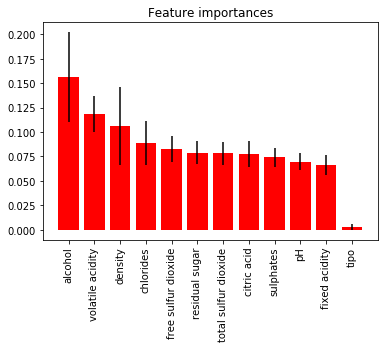

In [72]:
model = RandomForestClassifier(n_estimators=40, max_depth=19,n_jobs=-1)
model.fit(x_tr,y_tr)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
ts = []
for i in indices:
    ts.append(x_tr.keys()[i])
print("Feature ranking:")
for f in range(x_tr.shape[1]):
    print("%d. %s (%f)" % (f + 1, ts[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_tr.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_tr.shape[1]), ts, rotation='vertical')
plt.xlim([-1, x_tr.shape[1]])
plt.show()

Sobre AdaBoost, la idea de hacer un ranking de importancia de características es menos intuitiva. Random Forest realiza una especie de feature selection al elegir subconjuntos de características, mientras que AdaBoost solo podría realizar feature selección a través de los árboles mismos (por ejemplo, con stump). De cualquier modo, AdaBoost también trae una implementación de feature_importances_, pero concordando con nuestro análisis, los resultados no presentan información relevante.

Feature ranking:
1. chlorides (0.126503)
2. alcohol (0.119151)
3. citric acid (0.117443)
4. free sulfur dioxide (0.099019)
5. total sulfur dioxide (0.089945)
6. volatile acidity (0.088993)
7. pH (0.087702)
8. fixed acidity (0.073224)
9. residual sugar (0.068889)
10. density (0.064739)
11. sulphates (0.064380)
12. tipo (0.000014)


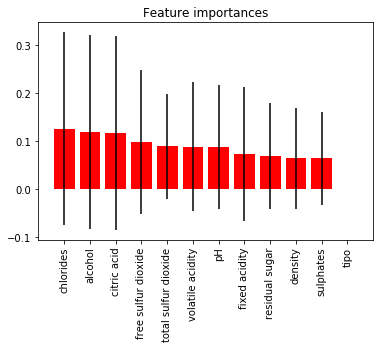

In [74]:
model = AdaBoostClassifier(base_estimator=Tree(max_depth=19), n_estimators=40)
model.fit(x_tr,y_tr)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
ts = []
for i in indices:
    ts.append(x_tr.keys()[i])
print("Feature ranking:")
for f in range(x_tr.shape[1]):
    print("%d. %s (%f)" % (f + 1, ts[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_tr.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_tr.shape[1]), ts, rotation='vertical')
plt.xlim([-1, x_tr.shape[1]])
plt.show()

<div id='4' />
### 4. Reconocimiento de Imágenes Sign Gestures

<div id='4a' />
##### (a) Construya una función que cargue todos los datos de entrenamiento y pruebas del problema generando como salida: (i) dos matrices $X_tr$, $Y_tr$, correspondientes a las imágenes y etiquetas de entrenamiento, (ii) dos matrices $X_t$, $Y_t$, correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos matrices $X_v$, $Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraído desde el conjunto de entrenamiento original y no debe superar las $7000$ imágenes.

El data set corresponde a 34627 imágenes de $28 \times 28$ pixeles. Cada imágen corresponde a una de 24 clases enumeradas desde 0 a 24 saltándose el 9.

In [75]:
def load_data():
    train = pd.read_csv('sign_mnist_train.csv')
    test = pd.read_csv('sign_mnist_test.csv')
    y_tr = train['label']
    x_tr = train.iloc[:,1:]
    y_t = test['label']
    x_t = test.iloc[:,1:]
    y_v = y_tr[:7000]
    x_v = x_tr[:7000]
    y_tr = y_tr[7000:]
    x_tr = x_tr[7000:]
    return(x_tr,x_v,x_t,y_tr,y_v,y_t)
x_tr, x_v, x_t, y_tr, y_v , y_t= load_data()

<div id='4b' />
##### (b) Construya una función que escale apropiadamente las imágenes antes de trabajar. Experimente sólo escalando los datos de acuerdo a la intensidad máxima de pixel (i.e., dividiendo por $255$) y luego centrando y escalándolos como en actividades anteriores.

Basta con realizar un escalamiento estándar, pues dividir cada pixel por $255$ no tendría efecto en la estandarización.

In [383]:
Scaler = StandardScaler().fit(x_tr)
x_tr = Scaler.transform(x_tr)
x_t  = Scaler.transform(x_t )
x_v  = Scaler.transform(x_v )
y_tr_cat = to_categorical(y_tr)
y_t_cat  = to_categorical(y_t )
y_v_cat  = to_categorical(y_v )

<div id='4c' />
##### (c) Diseñe, entrene y evalúe una red neuronal para el problema partir de la representación original de las imágenes. Experimente con distintas arquitecturas, pre-procesamientos y métodos de entrenamiento, midiendo el error de clasificación sobre el conjunto de validación. En base a esta última medida de desempeño, decida qué modelo, de entre todos los evaluados, medirá finalmente en el conjunto de test. Reporte y discuta los resultados obtenidos. Se espera que logre obtener un error de pruebas menor o igual a $0.2$.

Se probaron las siguientes configuraciones:
* Arquitectura: 
 * 3 capas ocultas de 10 neuronas cada una
 * 2 capas ocultas de 30 neuronas cada una
 * 1 capa oculta de 10 neuronas
 * 1 capa oculta de 50 neuronas
 * 1 capa oculta de 200 neuronas
* Función de activación en capas ocultas:
 * sigmoid
 * tanh
 * relu
* Hiper-parámetros:
 * Learning-rate: 1, 0.5, 0.1, 0.05, 0.005
 * Batch-size: 32, 64, 128, 256
* Preprocesamiento:
 * LDA (2, 6 y 10 dimensiones)
 * PCA (2, 6 y 10 dimensiones)
 
Es claro que lo óptimo es realizar todas las combinaciones posibles, pero entrenar $5 \times 3 \times 5 \times 4 \times 7 = 2100$ redes neuronales resulta casi imposible en el marco y plazo de una tarea. La decisión tomada es usar para cierto parámetro la configuración mostrada en el enunciado de la tarea mientras no haya sido evaluado. Luego de encontrar el mejor valor para este parámetro, nos quedamos con dicho valor para futuras experimentaciones de los parámetros restantes. En otras palabras eligiremos lo mejor de cada categoría mencionada sin tomar en cuenta las demás.

In [384]:
def err_plot(es):
    plt.figure(figsize=(15,4))
    for lab,errors in es: 
        plt.plot(range(1,51),errors,label=str(lab))
    plt.title("Error de clasificacion (Conjunto de validacion)")
    plt.xlabel("Numero de epocas")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

Arquitectura: 3 capas ocultas de 10 neuronas.
Error luego de 50 epocas: 0.154714285782
Arquitectura: 2 capas ocultas de 30 neuronas.
Error luego de 50 epocas: 0.000285714285714
Arquitectura: 1 capa oculta de 10 neuronas.
Error luego de 50 epocas: 0.00942857142857
Arquitectura: 1 capa oculta de 50 neuronas.
Error luego de 50 epocas: 0.0
Arquitectura: 1 capa oculta de 200 neuronas.
Error luego de 50 epocas: 0.0


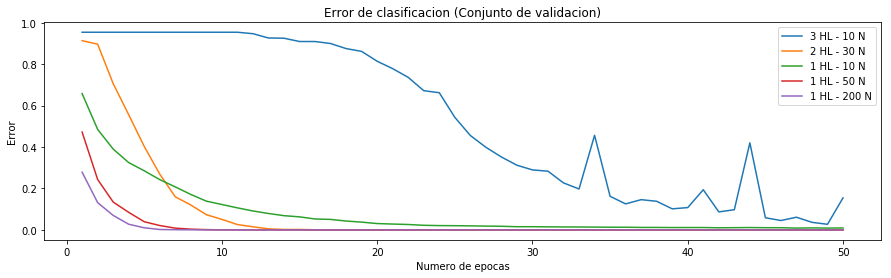

In [386]:
es = []
for arq in range(5):
    model = Sequential()
    if arq == 0:
        lab = "3 HL - 10 N"
        print "Arquitectura: 3 capas ocultas de 10 neuronas."
        model.add(Dense(10, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
        model.add(Dense(10, kernel_initializer='uniform', activation='relu'))
        model.add(Dense(10, kernel_initializer='uniform', activation='relu'))
        model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    elif arq == 1:
        lab = "2 HL - 30 N"
        print "Arquitectura: 2 capas ocultas de 30 neuronas."
        model.add(Dense(30, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
        model.add(Dense(30, kernel_initializer='uniform', activation='relu'))
        model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    elif arq == 2:
        lab = "1 HL - 10 N"
        print "Arquitectura: 1 capa oculta de 10 neuronas."
        model.add(Dense(10, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
        model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    elif arq == 3:
        lab = "1 HL - 50 N"
        print "Arquitectura: 1 capa oculta de 50 neuronas."
        model.add(Dense(50, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
        model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    else:
        lab = "1 HL - 200 N"
        print "Arquitectura: 1 capa oculta de 200 neuronas."
        model.add(Dense(200, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
        model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
    errors = []
    for i in range(50):
        model.fit(x_tr, y_tr_cat, epochs=1, batch_size=128, verbose=0, validation_data=(x_v,y_v_cat))
        scores = model.evaluate(x_v, y_v_cat, verbose=0)
        errors.append(1-scores[1])
    print "Error luego de 50 epocas:", errors[-1]
    es.append((lab,errors))
err_plot(es)

Funcion de Activacion: sigmoid
Error luego de 50 epocas: 0.000428571428571
Funcion de Activacion: tanh
Error luego de 50 epocas: 0.0
Funcion de Activacion: relu
Error luego de 50 epocas: 0.0


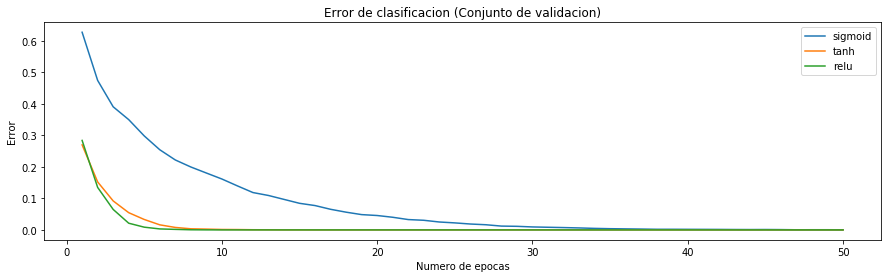

In [387]:
es=[]
for act in ["sigmoid","tanh","relu"]:
    print "Funcion de Activacion:", act
    model = Sequential()
    model.add(Dense(200, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation=act))
    model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
    errors = []
    for i in range(50):
        model.fit(x_tr, y_tr_cat, epochs=1, batch_size=128, verbose=0, validation_data=(x_v,y_v_cat))
        scores = model.evaluate(x_v, y_v_cat, verbose=0)
        errors.append(1-scores[1])
    print "Error luego de 50 epocas:", errors[-1]
    es.append((act,errors))
err_plot(es)

Learning Rate: 1
Error luego de 50 epocas: 0.261571428571
Learning Rate: 0.5
Error luego de 50 epocas: 0.0
Learning Rate: 0.1
Error luego de 50 epocas: 0.0
Learning Rate: 0.05
Error luego de 50 epocas: 0.0
Learning Rate: 0.005
Error luego de 50 epocas: 0.0107142857143


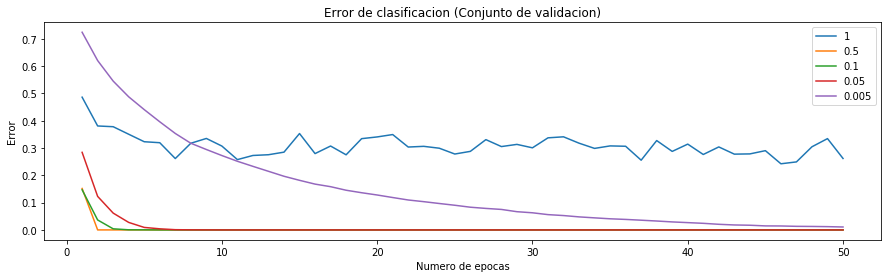

In [388]:
es = []
for l_r in [1,0.5,0.1,0.05,0.005]:
    print "Learning Rate:", l_r
    model = Sequential()
    model.add(Dense(200, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=l_r), loss='categorical_crossentropy', metrics=['accuracy'])
    errors = []
    for i in range(50):
        model.fit(x_tr, y_tr_cat, epochs=1, batch_size=128, verbose=0, validation_data=(x_v,y_v_cat))
        scores = model.evaluate(x_v, y_v_cat, verbose=0)
        errors.append(1-scores[1])
    print "Error luego de 50 epocas:", errors[-1]
    es.append((l_r,errors))
err_plot(es)

Batch Size: 32
Error luego de 50 epocas: 0.762
Tiempo de ejecucion: 45.5399999619
Batch Size: 64
Error luego de 50 epocas: 0.282285714286
Tiempo de ejecucion: 35.4649999142
Batch Size: 128
Error luego de 50 epocas: 0.0
Tiempo de ejecucion: 32.6849999428
Batch Size: 256
Error luego de 50 epocas: 0.0
Tiempo de ejecucion: 32.0169999599


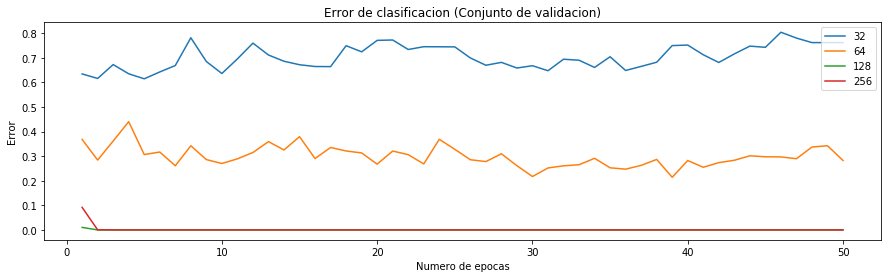

In [389]:
es=[]
for b_s in [32,64,128,256]:
    print "Batch Size:", b_s
    model = Sequential()
    model.add(Dense(200, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
    errors = []
    start=time.time()
    for i in range(50):
        model.fit(x_tr, y_tr_cat, epochs=1, batch_size=b_s, verbose=0, validation_data=(x_v,y_v_cat))
        scores = model.evaluate(x_v, y_v_cat, verbose=0)
        errors.append(1-scores[1])
    print "Error luego de 50 epocas:", errors[-1]
    print "Tiempo de ejecucion:", time.time()-start
    es.append((b_s,errors))
err_plot(es)

Preprocesamiento: Normal
Error luego de 50 epocas: 0.000714285714286
Preprocesamiento: PCA - 2
Error luego de 50 epocas: 0.92042857142
Preprocesamiento: PCA - 6
Error luego de 50 epocas: 0.518714285714
Preprocesamiento: PCA - 10
Error luego de 50 epocas: 0.347714285646


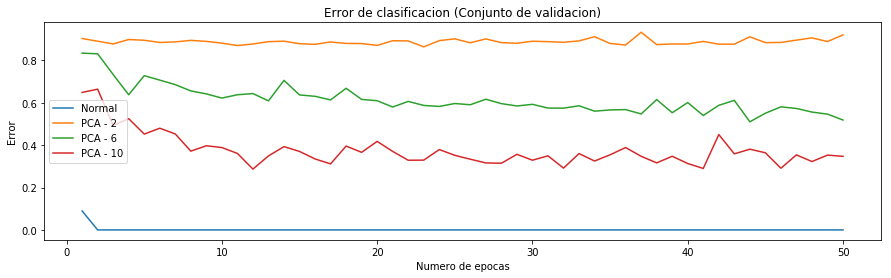

In [390]:
es=[]
for c in [0,2,6,10]:
    if c == 0:
        lab = 'Normal'
        x_tr_pca = x_tr
        x_v_pca  = x_v
    else:
        lab = 'PCA - '+str(c)
        pca = PCA(n_components=c)
        pca.fit(x_tr)
        x_tr_pca = pca.transform(x_tr)
        x_v_pca  = pca.transform(x_v)
    print "Preprocesamiento:", lab
    model = Sequential()
    model.add(Dense(200, input_dim=x_tr_pca.shape[1], kernel_initializer='uniform', activation="relu"))
    model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
    errors = []
    for i in range(50):
        model.fit(x_tr_pca, y_tr_cat, epochs=1, batch_size=128, verbose=0, validation_data=(x_v_pca,y_v_cat))
        scores = model.evaluate(x_v_pca, y_v_cat, verbose=0)
        errors.append(1-scores[1])
    print "Error luego de 50 epocas:", errors[-1]
    es.append((lab,errors))
err_plot(es)

Preprocesamiento: Normal
Error luego de 50 epocas: 0.000714285714286
Preprocesamiento: LDA - 2
Error luego de 50 epocas: 0.566428571395
Preprocesamiento: LDA - 6
Error luego de 50 epocas: 0.132285714218
Preprocesamiento: LDA - 10
Error luego de 50 epocas: 0.0197142857143


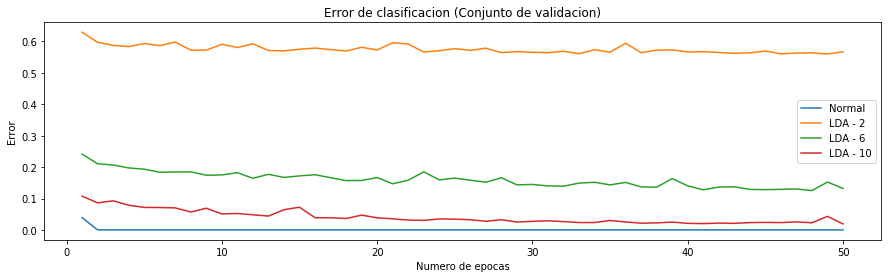

In [396]:
es=[]
for c in [0,2,6,10]:
    if c == 0:
        lab = 'Normal'
        x_tr_lda = x_tr
        x_v_lda  = x_v
    else:
        lab = 'LDA - '+str(c)
        lda = LDA(n_components=c)
        lda.fit(x_tr,y_tr)
        x_tr_lda = lda.transform(x_tr)
        x_v_lda  = lda.transform(x_v)
    print "Preprocesamiento:", lab
    model = Sequential()
    model.add(Dense(200, input_dim=x_tr_lda.shape[1], kernel_initializer='uniform', activation="relu"))
    model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
    errors = []
    for i in range(50):
        model.fit(x_tr_lda, y_tr_cat, epochs=1, batch_size=128, verbose=0, validation_data=(x_v_lda,y_v_cat))
        scores = model.evaluate(x_v_lda, y_v_cat, verbose=0)
        errors.append(1-scores[1])
    print "Error luego de 50 epocas:", errors[-1]
    es.append((lab,errors))
err_plot(es)

Luego de toda la experimentación mostrada, la mejor configuración corresponde a:
* Arquitectura: 1 capa oculta de 200 neuronas
* Función de activación en capas ocultas: relu
* Hiper-parámetros:
 * Learning-rate: 0.5
 * Batch-size: 128
* Preprocesamiento: Datos sin preprocesamiento

A continuación mostramos el error de esta configuración sobre el testing set, logrando la meta indicada en el enunciado de un error menor a $0.2$.

In [397]:
model = Sequential()
model.add(Dense(200, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation="relu"))
model.add(Dense(25, kernel_initializer='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_tr, y_tr_cat, epochs=100, batch_size=128, verbose=0, validation_data=(x_v,y_v_cat))
scores = model.evaluate(x_t, y_t_cat, verbose=0)
print "Error en el conjunto de prueba:", 1-scores[1]

Error en el conjunto de prueba: 0.189486893475


<div id='4d' />
##### (d) Para la mejor red entrenada anteriormente construya la matriz de confusión de las distintas clases, para asi visualizar cuáles son las clases más difíciles de clasificar y con cuáles se confunden. Comente.

Gracias a esta matriz podemos ver como todos los ejemplos de las clases 0, 11 y 15 fueron etiquetados perfectamente. Recordar que las clases reales se saltan el 9, por lo que al decir 11 y 15 nos estamos refiriendo a las filas y columnas 10 y 14 respectivamente. Las clases 10, 13, 18 y 20 presentan varios ejemplos mal etiquetados, aunque no podríamos afirmar que dos clases "se confunden". El caso más cercano corresponde a las clases 10 y 20, en donde 60 ejemplos de la última fueron etiquetados como la primera, siendo éste el mayor valor fuera de la diagonal de la matriz de confusión.

In [398]:
y_pred = model.predict(x_t)
y_pred_conf = y_pred.argmax(1)
y_t_conf = y_t_cat.argmax(1)
cm = confusion_matrix(y_t_conf, y_pred_conf)

In [399]:
cmm = pd.DataFrame(cm)
pd.options.display.max_columns = 24
cmm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,411,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0
2,0,0,289,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,240,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0
4,0,0,0,0,477,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0
5,0,0,21,0,0,226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,307,0,0,0,0,0,0,0,1,20,0,0,20,0,0,0,0,0
7,0,0,0,0,0,0,41,355,0,0,0,19,0,0,0,0,0,0,0,21,0,0,0,0
8,0,0,0,0,0,0,0,0,228,18,0,0,0,0,0,0,21,0,0,0,0,0,0,21
9,0,0,0,0,0,21,0,0,21,208,0,0,0,0,0,0,28,0,0,31,0,2,0,20


<div id='4e' />
##### (e) Entrene una SVM no lineal sobre los pixeles con y sin pre-procesamiento. Puede utilizar el conjunto de validación para seleccionar hiper-parámetros, como el nivel de regularización aplicado y/o la función de kernel a utilizar.

Se decidió evaluar el valor de $C$ y la función de kernel. Para el parámetro $C$, los valores más grandes presentan un score muy superior, pero al mismo tiempo un tiempo de ejecución muy superior (recomendamos no volver a ejecutar esta celda al evaluar). Si bien utilizar un valor de $C=100$ presenta un score casi perfecto, la diferencia no es muy elevada con respecto a $C=10$, pero se demora 8 veces más, por lo que se decidió elegir $C=10$ en virtud de este trade-off. Por otro lado, el kernel por defecto (rbf) tuvo un desempeño muy superior a todos los demás probados. 

Aun así, la red neuronal entrenada anteriormente tuvo menor error en el conjunto de testing que la SVM implementada en esta pregunta.

In [427]:
scor = []
for c in [0.1,1,10,100]:
    print 'C =', c
    start = time.time()
    model = SVR(C=c)
    model.fit(x_tr,y_tr)
    sc = model.score(x_v,y_v)
    print "Score:", sc
    print "Tiempo de ejecucion:", time.time()-start
    scor.append(sc)

C = 0.1
Score: 0.435985984532
Tiempo de ejecucion: 555.825999975
C = 1
Score: 0.801564667387
Tiempo de ejecucion: 499.735000134
C = 10
Score: 0.977788977569
Tiempo de ejecucion: 2193.31900001
C = 100
Score: 0.99315166544
Tiempo de ejecucion: 17291.619


In [428]:
scor = []
for ker in ['linear','poly','rbf','sigmoid']:
    print 'Kernel =', ker
    model = SVR(C=1,kernel=ker)
    model.fit(x_tr,y_tr)
    sc = model.score(x_v,y_v)
    print "Score:", sc
    scor.append(sc)

Kernel = linear
Score: 0.61364165383
Kernel = poly
Score: 0.621248963816
Kernel = rbf
Score: 0.801564667387
Kernel = sigmoid
Score: -2091.91669144


In [429]:
model = SVR(C=10)
model.fit(x_tr,y_tr)
sc = model.score(x_t,y_t)
print "Error en el conjunto de prueba:", 1-sc

Error en el conjunto de prueba: 0.251971907022


<div id='4f' />
##### (f) Entrene una árbol de clasificación sobre los pixeles con y sin pre-procesamiento. Puede utilizar el conjunto de validación para seleccionar hiper-parámetros, como la profundidad máxima del árbol.

Solo se probó variar la profundidad del árbol, encontrando un mínimo error en una altura de 28. También se realizaron preprocesamientos de los datos con LDA y PCA, encontrando el mejor resultado en LDA. Finalmente, el error presentado por este árbol es muy inferior a cualquiera de los vistos anteriormente, resultando ser el mejor clasificador para este caso.

In [404]:
err = []
for depth in range(1,30):
    clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=depth)
    clf.fit(x_tr,y_tr)
    err.append(1-clf.score(x_v, y_v))

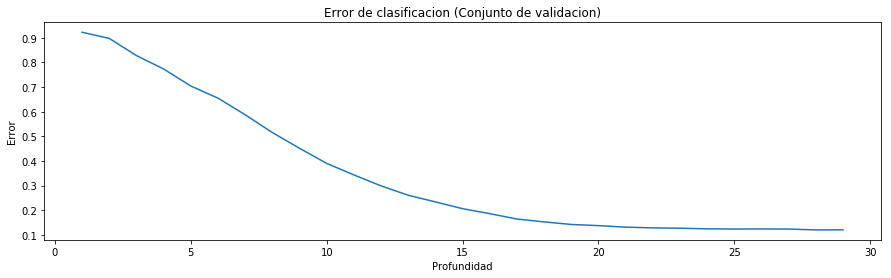

In [405]:
plt.figure(figsize=(15,4))
plt.plot(range(1,30),err)
plt.title("Error de clasificacion (Conjunto de validacion)")
plt.xlabel("Profundidad")
plt.ylabel("Error")
plt.show()

In [414]:
errPCA = []
errLDA = []
for c in range(2,11):
    lda = LDA(n_components=c)
    lda.fit(x_tr,y_tr)
    x_tr_lda = lda.transform(x_tr)
    x_v_lda  = lda.transform(x_v)
    clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=28)
    clf.fit(x_tr_lda,y_tr)
    errLDA.append(1-clf.score(x_v_lda, y_v))
    
    pca = PCA(n_components=c)
    pca.fit(x_tr,y_tr)
    x_tr_pca = pca.transform(x_tr)
    x_v_pca  = pca.transform(x_v)
    clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=28)
    clf.fit(x_tr_pca,y_tr)
    errPCA.append(1-clf.score(x_v_pca, y_v))

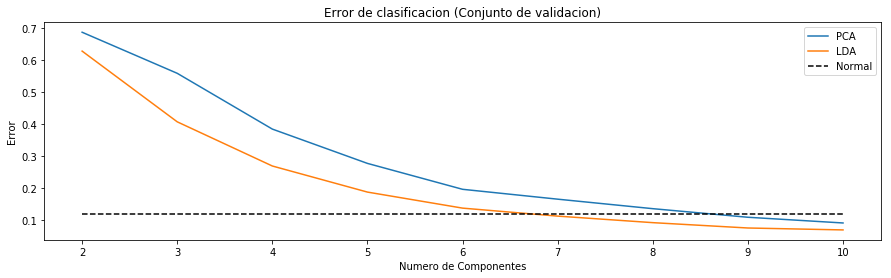

In [416]:
plt.figure(figsize=(15,4))
plt.plot(range(2,11),errPCA,label='PCA')
plt.plot(range(2,11),errLDA,label='LDA')
plt.plot([2,10],[err[27],err[27]],'k--',label='Normal')
plt.title("Error de clasificacion (Conjunto de validacion)")
plt.xlabel("Numero de Componentes")
plt.ylabel("Error")
plt.legend(loc='best')
plt.show()

In [417]:
lda = LDA(n_components=10)
lda.fit(x_tr,y_tr)
x_tr_lda = lda.transform(x_tr)
x_t_lda  = lda.transform(x_t)
clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=28)
clf.fit(x_tr_lda,y_tr)
print "Error en el conjunto de prueba:", 1-clf.score(x_v_lda, y_v)

Error en el conjunto de prueba: 0.0687142857143
